In [5]:
import sys
sys.path.append('../')
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
hyperparams = {
    # 'learning_rate': 5e-4,  # Control dropout rate
    'learning_rate': 5e-4,  # Control dropout rate
    'patience': 4,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}

num_epochs = 10
print_every = 1

hidden_sizes1 = 128
hidden_sizes2 = 1024
hidden_sizes3 = 128
num_hidden = 5
hidden_sizes1 = 128
hidden_sizes2 = 1024
hidden_sizes3 = 128
num_hidden = 10

In [7]:
knot_types = {
        'standard_16': 0,  # 1
        'standard_14': 1,  # 2
        'standard_18': 2,  # 3
        '30both': 3,  # 4
        '30oneZ': 4,  # 5
        'optimized': 5,  # 6
        'pm_03_z': 6,  # 7
        # '4foil': hopf_4foil,  # 8
        # '6foil': hopf_6foil,  # 9
        # 'stand4foil': hopf_stand4foil,  # 10
        '30oneX': 7,  # 11
        '15oneZ': 8,
        'dennis': 9,
        'trefoil_standard_12': 10,
        'trefoil_optimized': 11,
        # 'fivefoil_standard_08': fivefoil_standard_08

}


knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]


folders = [
    '../HOPFS_L270_0.05_1000_64x64x64_v1',
    '../HOPFS_L270_0.15_1000_64x64x64_v1',
    '../HOPFS_L270_0.25_1000_64x64x64_v1',
]
# folders = [
#     '../HOPFS_L270_0.05_1_64x64x64_v1',
#     '../HOPFS_L270_5e-07_test_1s',
# ]


num_classes = len(knots)
X_list = []
Y_list = []
Xs_list = []
Ys_list = []

csv.field_size_limit(10000000)

# Loop through all folders and knots
for folder in folders:
    for knot in knots:
        filename = f'{folder}/data_{knot}_spectr.csv'
        try:
            with open(filename, 'r') as file:
                reader = csv.reader(file)
                for row in reader:
                    # Append the knot label to Ys_list
                    Ys_list.append(knot_types[knot])

                    # Load the data array from the JSON string
                    data_array = json.loads(row[0])

                    # Extract values from the data array
                    l1, l2 = data_array[0], data_array[1]
                    p1, p2 = data_array[2], data_array[3]

                    # Create and normalize the moments array
                    moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]])
                    moments = moments.reshape((l2 - l1 + 1), (p2 - p1 + 1))
                    moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))

                    # Append the flattened absolute values to Xs_list
                    Xs_list.append(np.abs(moments.reshape(-1)))

        except FileNotFoundError:
            print(f'File not found: {filename}')
        except json.JSONDecodeError:
            print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Loaded 0 samples.  0 per class


In [8]:
Xs_np = np.array(Xs_list)
ys_np = np.array(Ys_list)
# print(ys_np.shape)
Xs_torch = torch.tensor(Xs_np).float()
ys_t = torch.tensor(ys_np)
ys_torch = F.one_hot(ys_t.long(), num_classes=num_classes).float()
print(Xs_torch.shape, ys_torch.shape)

torch.Size([132, 91]) torch.Size([132, 12])


In [9]:
X_train, X_val_test, y_train, y_val_test = train_test_split(Xs_torch, ys_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [10]:

class ClassifierFC_spec(nn.Module):
    def __init__(self, input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3, num_hidden, num_classes):
        super(ClassifierFC_spec, self).__init__()
        layers = []
        # Create input layer with batch normalization
        layers.append(nn.Linear(input_size, hidden_sizes1, bias=True))
        layers.append(nn.BatchNorm1d(hidden_sizes1))  # Batch normalization
        layers.append(nn.ReLU())

        # Add second layer with batch normalization
        layers.append(nn.Linear(hidden_sizes1, hidden_sizes2, bias=True))
        layers.append(nn.BatchNorm1d(hidden_sizes2))  # Batch normalization
        layers.append(nn.ReLU())

        # Create hidden layers with batch normalization
        for i in range(0, num_hidden):
            layers.append(nn.Linear(hidden_sizes2, hidden_sizes2, bias=True))
            layers.append(nn.BatchNorm1d(hidden_sizes2))  # Batch normalization
            layers.append(nn.ReLU())

        # Create output layers with batch normalization
        layers.append(nn.Linear(hidden_sizes2, hidden_sizes3, bias=True))
        layers.append(nn.BatchNorm1d(hidden_sizes3))  # Batch normalization
        layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_sizes3, num_classes))

        # ModuleList of all layers
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            # print(x.shape)
        return x

In [11]:
# in_channels, out_channels, kernel_size, stride, padding
input_size = Xs_np.shape[-1]

num_classes = ys_torch.shape[-1]
model = ClassifierFC_spec(input_size, hidden_sizes1, hidden_sizes2, hidden_sizes3,
                          num_hidden, num_classes).to(device)

In [12]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:4][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch).shape)
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([3, 91])
torch.Size([3, 12])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          11,776
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                 [-1, 1024]         132,096
       BatchNorm1d-5                 [-1, 1024]           2,048
              ReLU-6                 [-1, 1024]               0
            Linear-7                 [-1, 1024]       1,049,600
       BatchNorm1d-8                 [-1, 1024]           2,048
              ReLU-9                 [-1, 1024]               0
           Linear-10                 [-1, 1024]       1,049,600
      BatchNorm1d-11                 [-1, 1024]           2,048
             ReLU-12                 [-1, 1024]               0
           Linear-13                 [-1, 1024]       1,049,600

In [13]:
train_dataset[1:2][0]

tensor([[4.6387e-05, 2.2017e-05, 4.1045e-05, 4.3364e-05, 2.6819e-05, 3.5398e-05,
         2.6810e-05, 4.1336e-05, 3.5944e-05, 1.1803e-06, 1.3765e-05, 6.1735e-06,
         1.2568e-05, 1.6452e-05, 8.3469e-05, 2.6047e-05, 1.8260e-04, 4.5117e-04,
         6.4492e-04, 4.3694e-04, 2.0579e-04, 9.1498e-05, 5.6196e-05, 3.7990e-05,
         2.1209e-05, 1.0520e-05, 1.6337e-05, 1.2209e-05, 1.2364e-04, 1.1329e-04,
         1.0256e-04, 2.9390e-05, 5.8968e-05, 9.2591e-05, 5.9887e-05, 3.1635e-04,
         4.6738e-04, 3.3220e-04, 8.1445e-05, 2.7949e-05, 3.5306e-05, 2.0466e-05,
         2.6292e-01, 6.3216e-01, 4.2105e-01, 1.3459e-04, 2.7177e-04, 7.0652e-04,
         9.1455e-04, 3.5986e-04, 6.0580e-04, 2.9552e-04, 9.4468e-05, 3.5680e-05,
         3.4238e-05, 1.9145e-05, 5.9494e-01, 1.6821e-04, 5.5187e-05, 6.0124e-05,
         6.0842e-05, 1.0935e-04, 7.2665e-05, 3.9111e-04, 7.7478e-05, 1.1014e-04,
         4.2463e-05, 1.5377e-05, 6.1185e-06, 8.5051e-06, 1.0105e-04, 5.5363e-05,
         1.6382e-04, 4.4759e

In [14]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [15]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)



train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')

Progress:   6%|▌         | 6/100 [00:00<00:04, 22.82it/s]

Epoch 0 completed in 0.20 seconds
Epoch 0: Train Loss: 2.4761, Val Loss: 2.5082
Epoch 1 completed in 0.02 seconds
Epoch 1: Train Loss: 1.5310, Val Loss: 2.5157
Epoch 2 completed in 0.02 seconds
Epoch 2: Train Loss: 0.8028, Val Loss: 2.5264
Epoch 3 completed in 0.02 seconds
Epoch 3: Train Loss: 0.5810, Val Loss: 2.5412
Epoch 4 completed in 0.02 seconds
Epoch 4: Train Loss: 0.6443, Val Loss: 2.5618
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5 completed in 0.02 seconds
Epoch 5: Train Loss: 0.4516, Val Loss: 2.5906
Epoch 6 completed in 0.02 seconds
Epoch 6: Train Loss: 0.4530, Val Loss: 2.6240
Epoch 7 completed in 0.02 seconds
Epoch 7: Train Loss: 0.4563, Val Loss: 2.6647
Epoch 8 completed in 0.02 seconds
Epoch 8: Train Loss: 0.4322, Val Loss: 2.7146
Epoch 9 completed in 0.02 seconds
Epoch 9: Train Loss: 0.3916, Val Loss: 2.7660


Progress:  16%|█▌        | 16/100 [00:00<00:02, 36.48it/s]

Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10 completed in 0.02 seconds
Epoch 10: Train Loss: 0.4485, Val Loss: 2.8007
Epoch 11 completed in 0.03 seconds
Epoch 11: Train Loss: 0.4877, Val Loss: 2.8344
Epoch 12 completed in 0.02 seconds
Epoch 12: Train Loss: 0.4145, Val Loss: 2.8447
Epoch 13 completed in 0.02 seconds
Epoch 13: Train Loss: 0.3761, Val Loss: 2.8587
Epoch 14 completed in 0.02 seconds
Epoch 14: Train Loss: 0.3866, Val Loss: 2.8560
Epoch 00016: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15 completed in 0.02 seconds
Epoch 15: Train Loss: 0.4611, Val Loss: 2.8445
Epoch 16 completed in 0.02 seconds
Epoch 16: Train Loss: 0.4354, Val Loss: 2.8333
Epoch 17 completed in 0.02 seconds
Epoch 17: Train Loss: 0.3417, Val Loss: 2.8152
Epoch 18 completed in 0.02 seconds
Epoch 18: Train Loss: 0.5890, Val Loss: 2.8198
Epoch 19 completed in 0.02 seconds
Epoch 19: Train Loss: 0.4503, Val Loss: 2.8058


Progress:  26%|██▌       | 26/100 [00:00<00:01, 40.90it/s]

Epoch 00021: reducing learning rate of group 0 to 8.0000e-07.
Epoch 20 completed in 0.02 seconds
Epoch 20: Train Loss: 0.4100, Val Loss: 2.7792
Epoch 21 completed in 0.02 seconds
Epoch 21: Train Loss: 0.3536, Val Loss: 2.7291
Epoch 22 completed in 0.02 seconds
Epoch 22: Train Loss: 0.3902, Val Loss: 2.6757
Epoch 23 completed in 0.02 seconds
Epoch 23: Train Loss: 0.4480, Val Loss: 2.6249
Epoch 24 completed in 0.02 seconds
Epoch 24: Train Loss: 0.3885, Val Loss: 2.5930
Epoch 00026: reducing learning rate of group 0 to 1.6000e-07.
Epoch 25 completed in 0.02 seconds
Epoch 25: Train Loss: 0.3897, Val Loss: 2.5788
Epoch 26 completed in 0.02 seconds
Epoch 26: Train Loss: 0.3341, Val Loss: 2.5823
Epoch 27 completed in 0.02 seconds
Epoch 27: Train Loss: 0.4541, Val Loss: 2.5321
Epoch 28 completed in 0.02 seconds
Epoch 28: Train Loss: 0.3515, Val Loss: 2.4693
Epoch 29 completed in 0.02 seconds
Epoch 29: Train Loss: 0.3749, Val Loss: 2.3469


Progress:  36%|███▌      | 36/100 [00:00<00:01, 43.42it/s]

Epoch 30 completed in 0.02 seconds
Epoch 30: Train Loss: 0.5042, Val Loss: 2.3006
Epoch 31 completed in 0.02 seconds
Epoch 31: Train Loss: 0.3349, Val Loss: 2.2349
Epoch 32 completed in 0.02 seconds
Epoch 32: Train Loss: 0.3649, Val Loss: 2.2107
Epoch 33 completed in 0.02 seconds
Epoch 33: Train Loss: 0.4405, Val Loss: 2.1392
Epoch 34 completed in 0.02 seconds
Epoch 34: Train Loss: 0.3695, Val Loss: 2.0761
Epoch 35 completed in 0.02 seconds
Epoch 35: Train Loss: 0.3402, Val Loss: 1.9616
Epoch 36 completed in 0.02 seconds
Epoch 36: Train Loss: 0.4859, Val Loss: 1.8350
Epoch 37 completed in 0.02 seconds
Epoch 37: Train Loss: 0.3635, Val Loss: 1.6718
Epoch 38 completed in 0.02 seconds
Epoch 38: Train Loss: 0.3697, Val Loss: 1.5115
Epoch 39 completed in 0.02 seconds
Epoch 39: Train Loss: 0.3539, Val Loss: 1.3662


Progress:  46%|████▌     | 46/100 [00:01<00:01, 45.01it/s]

Epoch 40 completed in 0.02 seconds
Epoch 40: Train Loss: 0.3822, Val Loss: 1.2390
Epoch 41 completed in 0.02 seconds
Epoch 41: Train Loss: 0.3483, Val Loss: 1.1131
Epoch 42 completed in 0.02 seconds
Epoch 42: Train Loss: 0.3788, Val Loss: 0.9901
Epoch 43 completed in 0.02 seconds
Epoch 43: Train Loss: 0.3451, Val Loss: 0.8855
Epoch 44 completed in 0.02 seconds
Epoch 44: Train Loss: 0.3664, Val Loss: 0.7920
Epoch 45 completed in 0.02 seconds
Epoch 45: Train Loss: 0.4885, Val Loss: 0.7312
Epoch 46 completed in 0.02 seconds
Epoch 46: Train Loss: 0.4939, Val Loss: 0.6880
Epoch 47 completed in 0.02 seconds
Epoch 47: Train Loss: 0.4261, Val Loss: 0.6518
Epoch 48 completed in 0.02 seconds
Epoch 48: Train Loss: 0.5135, Val Loss: 0.6360
Epoch 49 completed in 0.02 seconds
Epoch 49: Train Loss: 0.3656, Val Loss: 0.5863


Progress:  56%|█████▌    | 56/100 [00:01<00:00, 45.52it/s]

Epoch 50 completed in 0.02 seconds
Epoch 50: Train Loss: 0.3801, Val Loss: 0.5376
Epoch 51 completed in 0.02 seconds
Epoch 51: Train Loss: 0.4329, Val Loss: 0.5112
Epoch 52 completed in 0.02 seconds
Epoch 52: Train Loss: 0.3845, Val Loss: 0.5213
Epoch 53 completed in 0.02 seconds
Epoch 53: Train Loss: 0.3600, Val Loss: 0.5239
Epoch 54 completed in 0.02 seconds
Epoch 54: Train Loss: 0.3874, Val Loss: 0.5210
Epoch 55 completed in 0.02 seconds
Epoch 55: Train Loss: 0.4955, Val Loss: 0.5221
Epoch 00057: reducing learning rate of group 0 to 3.2000e-08.
Epoch 56 completed in 0.02 seconds
Epoch 56: Train Loss: 0.4440, Val Loss: 0.5126
Epoch 57 completed in 0.02 seconds
Epoch 57: Train Loss: 0.4471, Val Loss: 0.4931
Epoch 58 completed in 0.02 seconds
Epoch 58: Train Loss: 0.5504, Val Loss: 0.5003
Epoch 59 completed in 0.02 seconds
Epoch 59: Train Loss: 0.3641, Val Loss: 0.5144


Progress:  66%|██████▌   | 66/100 [00:01<00:00, 45.82it/s]

Epoch 60 completed in 0.02 seconds
Epoch 60: Train Loss: 0.4455, Val Loss: 0.4680
Epoch 61 completed in 0.02 seconds
Epoch 61: Train Loss: 0.3492, Val Loss: 0.4798
Epoch 62 completed in 0.02 seconds
Epoch 62: Train Loss: 0.4664, Val Loss: 0.4719
Epoch 63 completed in 0.02 seconds
Epoch 63: Train Loss: 0.3843, Val Loss: 0.4734
Epoch 64 completed in 0.02 seconds
Epoch 64: Train Loss: 0.4514, Val Loss: 0.4674
Epoch 65 completed in 0.02 seconds
Epoch 65: Train Loss: 0.5189, Val Loss: 0.4648
Epoch 66 completed in 0.02 seconds
Epoch 66: Train Loss: 0.3590, Val Loss: 0.4801
Epoch 67 completed in 0.02 seconds
Epoch 67: Train Loss: 0.4133, Val Loss: 0.4673
Epoch 68 completed in 0.02 seconds
Epoch 68: Train Loss: 0.5566, Val Loss: 0.4697
Epoch 69 completed in 0.02 seconds
Epoch 69: Train Loss: 0.3491, Val Loss: 0.4850


Progress:  76%|███████▌  | 76/100 [00:01<00:00, 45.79it/s]

Epoch 00071: reducing learning rate of group 0 to 6.4000e-09.
Epoch 70 completed in 0.02 seconds
Epoch 70: Train Loss: 0.3469, Val Loss: 0.4955
Epoch 71 completed in 0.02 seconds
Epoch 71: Train Loss: 0.4357, Val Loss: 0.5028
Epoch 72 completed in 0.02 seconds
Epoch 72: Train Loss: 0.3831, Val Loss: 0.4927
Epoch 73 completed in 0.02 seconds
Epoch 73: Train Loss: 0.4059, Val Loss: 0.4982
Epoch 74 completed in 0.02 seconds
Epoch 74: Train Loss: 0.4515, Val Loss: 0.4894
Epoch 75 completed in 0.02 seconds
Epoch 75: Train Loss: 0.5497, Val Loss: 0.4784
Epoch 76 completed in 0.02 seconds
Epoch 76: Train Loss: 0.3501, Val Loss: 0.4907
Epoch 77 completed in 0.02 seconds
Epoch 77: Train Loss: 0.5831, Val Loss: 0.4945
Epoch 78 completed in 0.02 seconds
Epoch 78: Train Loss: 0.3807, Val Loss: 0.4883
Epoch 79 completed in 0.02 seconds
Epoch 79: Train Loss: 0.3891, Val Loss: 0.4985


Progress:  86%|████████▌ | 86/100 [00:02<00:00, 44.92it/s]

Epoch 80 completed in 0.02 seconds
Epoch 80: Train Loss: 0.3685, Val Loss: 0.4995
Epoch 81 completed in 0.03 seconds
Epoch 81: Train Loss: 0.4478, Val Loss: 0.4790
Epoch 82 completed in 0.02 seconds
Epoch 82: Train Loss: 0.4784, Val Loss: 0.4765
Epoch 83 completed in 0.02 seconds
Epoch 83: Train Loss: 0.4925, Val Loss: 0.4646
Epoch 84 completed in 0.02 seconds
Epoch 84: Train Loss: 0.3844, Val Loss: 0.4723
Epoch 85 completed in 0.02 seconds
Epoch 85: Train Loss: 0.3606, Val Loss: 0.4848
Epoch 86 completed in 0.03 seconds
Epoch 86: Train Loss: 0.4120, Val Loss: 0.4854
Epoch 87 completed in 0.02 seconds
Epoch 87: Train Loss: 0.3467, Val Loss: 0.4964
Epoch 88 completed in 0.02 seconds
Epoch 88: Train Loss: 0.3477, Val Loss: 0.4966
Epoch 89 completed in 0.02 seconds
Epoch 89: Train Loss: 0.4211, Val Loss: 0.4869


Progress: 100%|██████████| 100/100 [00:02<00:00, 42.05it/s]

Epoch 90 completed in 0.02 seconds
Epoch 90: Train Loss: 0.4874, Val Loss: 0.4922
Epoch 91 completed in 0.02 seconds
Epoch 91: Train Loss: 0.3575, Val Loss: 0.4990
Epoch 92 completed in 0.02 seconds
Epoch 92: Train Loss: 0.5777, Val Loss: 0.4688
Epoch 93 completed in 0.02 seconds
Epoch 93: Train Loss: 0.5137, Val Loss: 0.4865
Epoch 94 completed in 0.02 seconds
Epoch 94: Train Loss: 0.3916, Val Loss: 0.4778
Epoch 95 completed in 0.02 seconds
Epoch 95: Train Loss: 0.3823, Val Loss: 0.4843
Epoch 96 completed in 0.02 seconds
Epoch 96: Train Loss: 0.3434, Val Loss: 0.4938
Epoch 97 completed in 0.02 seconds
Epoch 97: Train Loss: 0.4611, Val Loss: 0.4906
Epoch 98 completed in 0.02 seconds
Epoch 98: Train Loss: 0.4042, Val Loss: 0.5016
Epoch 99 completed in 0.02 seconds
Epoch 99: Train Loss: 0.3940, Val Loss: 0.5018
Total training time: 2.43 seconds


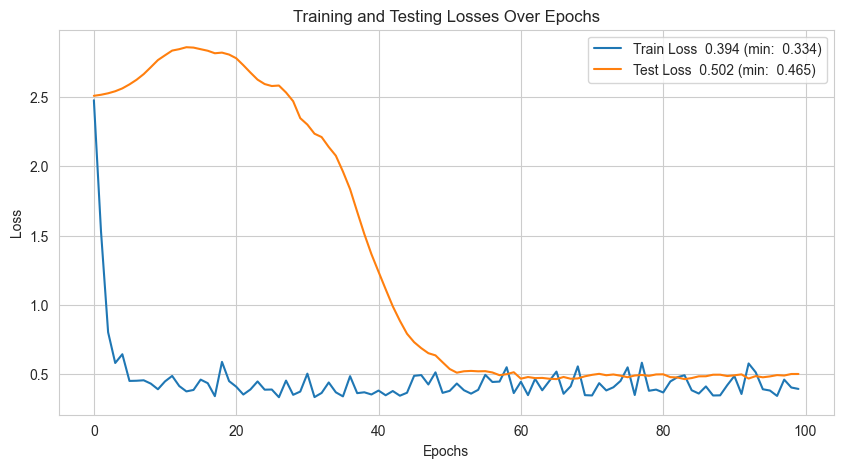

In [16]:
plot_losses(train_losses, val_losses, decimals=3)

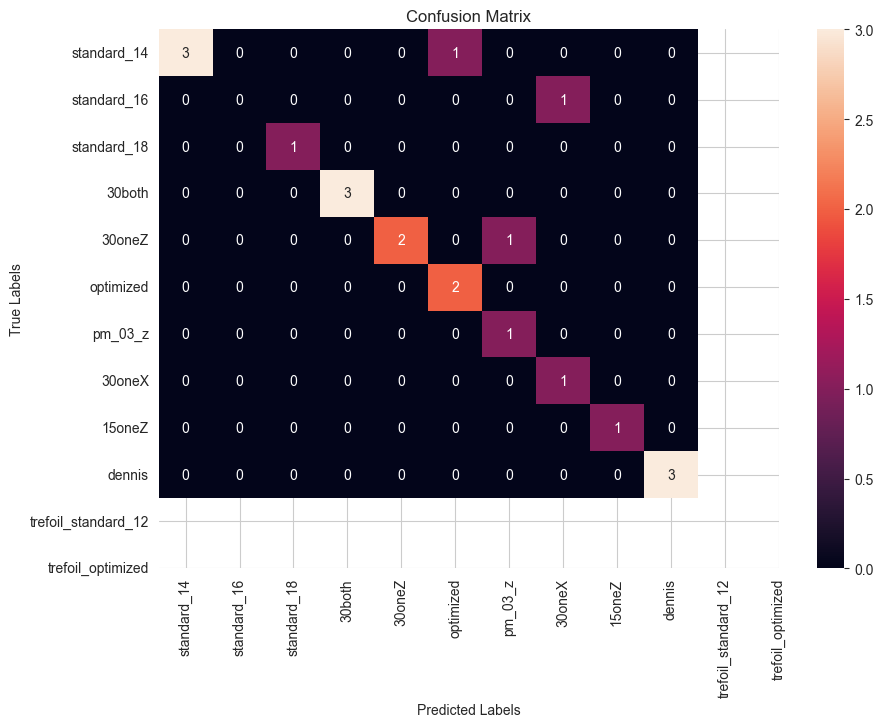

In [17]:
# predictions = model(X_torch.to(device))
# predictions
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

0.85


In [21]:
# Save the model state (weights) and structure
model_save_path = "classifier_FC_10_b.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparams': hyperparams,
    'num_classes': num_classes,
    'hidden_sizes1': hidden_sizes1,
    'hidden_sizes2': hidden_sizes2,
    'hidden_sizes3': hidden_sizes3,
    'num_hidden': num_hidden,
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to classifier3d_FC.pth
